In [1]:
from arcgis.features import *
from arcgis.gis import GIS
from arcgis.features.enrich_data import enrich_layer

import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
%matplotlib inline

In [2]:
#Initiative
initiative_id = 'b04ef2c7a77a43218b3e70dd75cc4f5e'
#Enrich Variables
enrich_variables = ['TOTPOP_CY', 'MEDHINC_CY']

### Connect to Hub

In [3]:
gis = GIS("https://dc.mapsqa.arcgis.com", "dcadminqa", "password")
myHub = gis.hub
data_inventory = myHub.initiatives.get(initiative_id)

### Indicator processing

In [4]:
def preprocessing(initiative, indicator_id):
    '''Fetch indicator and print total count'''
    #Fetch indicator
    indicator = initiative.indicators.get(indicator_id)
    indicator_itemid = indicator.itemid
    indicator_item = gis.content.get(indicator_itemid)
    indicator_flayer = indicator_item.layers[0]
    indicator_df = pd.DataFrame.spatial.from_layer(indicator_flayer)
    print('Total number of '+indicator_id+': '+str(indicator_df.shape[0]))
    return (indicator_df, indicator)

### Utility Functions for `measure`

In [5]:
def format_date(date):
    '''Return date in Y-M-D'''
    epoch_time = str(date)[0: 10]
    return epoch_time

In [6]:
def week_day(num):
    '''Return Weekday/Weekend'''
    if num < 4:
        return 'Weekday'
    if num >= 4:
        return 'Weekend'

In [7]:
def month(date):
    '''Return month number'''
    return str(date)[5:7]

### Place Dashboard script

In [8]:
def dashboard_place(initiative, place_id):
    '''Function that creates dashboard for place'''
    place, place_indicator = preprocessing(initiative, place_id)
    category_columnName = []
    for attribute in place_indicator.mappings:
        if attribute['type'] == 'esriFieldTypeString':
            category_columnName.append(attribute)
            
    #Bar chart for 1st category
    counts1 = place[category_columnName[0]['name']].value_counts()
    #Generates bar graph
    ax = counts1.plot(kind='barh', figsize=(10, 10), legend=True, fontsize=12, color='green')
    #X axis text and display style of categories
    ax.set_xlabel("Count", fontsize=12)
    #Y axis text
    ax.set_ylabel(category_columnName[0]['name'], fontsize=12)
    #Title
    ax.set_title("Bar chart for attribute "+category_columnName[0]['name'], fontsize=20)
    plt.show()
    
    #Bar chart for 2nd category
    counts2 = place[category_columnName[1]['name']].value_counts()
    #Generates bar graph
    ax = counts2.plot(kind='barh', figsize=(10, 10), legend=True, fontsize=12, color='purple')
    #X axis text and display style of categories
    ax.set_xlabel("Count", fontsize=12)
    #Y axis text
    ax.set_ylabel(category_columnName[1]['name'], fontsize=12)
    #Title
    ax.set_title("Bar chart for attribute "+category_columnName[1]['name'], fontsize=20)
    plt.show()

In [9]:
def dashboard_measure(initiative, measure_id):
    '''Function that creates dashboard for measure'''
    measure, measure_indicator = preprocessing(initiative, measure_id)
    dashboard_place(initiative, measure_id)
    date_columnName = next(field['name'] for field in measure_indicator.mappings if field['type'] == 'esriFieldTypeDate')
    
    #Extracting date in required format
    measure['date'] = measure[date_columnName].apply(format_date)
    measure['date'] = pd.to_datetime(measure['date']).dt.date
    measure['day_of_week'] = measure['date'].apply(lambda x: x.weekday()) 
    measure['day'] = measure['day_of_week'].apply(week_day)
    measure['month'] = measure['date'].apply(month)
    measure['month'] = measure['month'].astype(int)
    
    #Pie chart for weekday-weekend
    types = list(measure['day'].unique())
    sizes = measure['day'].value_counts()
    #Data to plot
    colors = ['yellow', 'orange']
    explode = (0.05, 0.015)  # explode 1st slice
    #Plot
    plt.pie(sizes, explode=explode, labels=types, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=100)
 
    plt.axis('equal')
    plt.show()
    
    #Histogram for monthly distribution
    plt.figure(figsize=(8,8))
    n, bins, patches = plt.hist(measure['month'], bins=[1,2,3,4,5,6,7,8,9,10,11,12], facecolor='blue', alpha=0.5)
    plt.title("Number of incidents for every month", fontsize=16)
    plt.xlabel("Month (January - December)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.show()

In [10]:
def dashboard_boundary(initiative, boundary_id):
    '''Function that creates dashboard for boundary'''
    boundary, boundary_indicator = preprocessing(initiative, boundary_id)
    
    #Build choropleth map
    enriched = enrich_layer(boundary_indicator.url, analysis_variables=enrich_variables, output_name='boundaryEnriched_'+initiative.itemid+'_'+boundary_id+str(int(time.time())))
    map1 = gis.map(enriched)
    map1.add_layer({"type":"FeatureLayer",
                "url": enriched.url,
                "renderer":"ClassedColorRenderer",
                "field_name":"TOTPOP_CY",
                "opacity":0.75
               })
    
    #Convert enriched to table
    enriched_flayer = enriched.layers[0]
    enriched_df = pd.DataFrame.spatial.from_layer(enriched_flayer)
    
    #Scatter plot
    fig, ax =  plt.subplots(figsize=(8,8))
    scatter = plt.scatter(enriched_df['TOTPOP_CY'], enriched_df['MEDHINC_CY'], c='blue', alpha=0.6)

    #X axis text and display style of categories
    ax.set_xlabel("Population per boundary", fontsize=14)
    #plt.xticks(rotation=45)

    #Y axis text
    ax.set_ylabel("Median household income per boundary", fontsize=14)

    #Title
    ax.set_title("Population v/s Median Household Income", fontsize=20)

    #Tooltip
    for i, name in enumerate(enriched_df['NAME']):
        ax.annotate(name, (enriched_df['TOTPOP_CY'][i], enriched_df['MEDHINC_CY'][i]))
    plt.show()
    return map1

### Example for `measure` (crime)

Total number of crime: 33082
Total number of crime: 33082


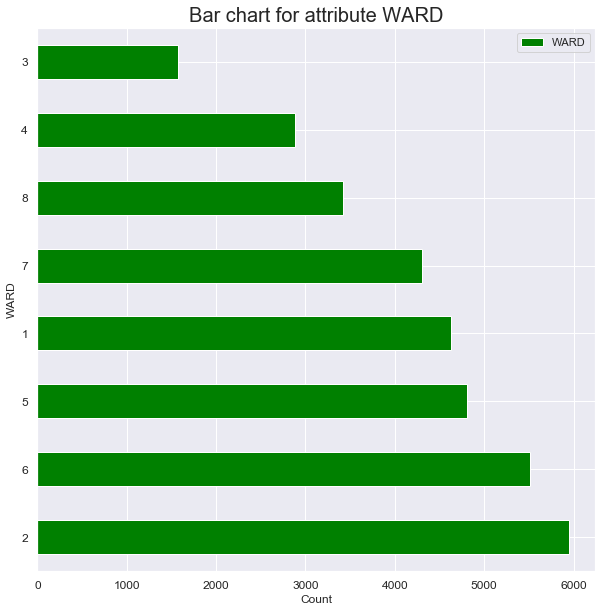

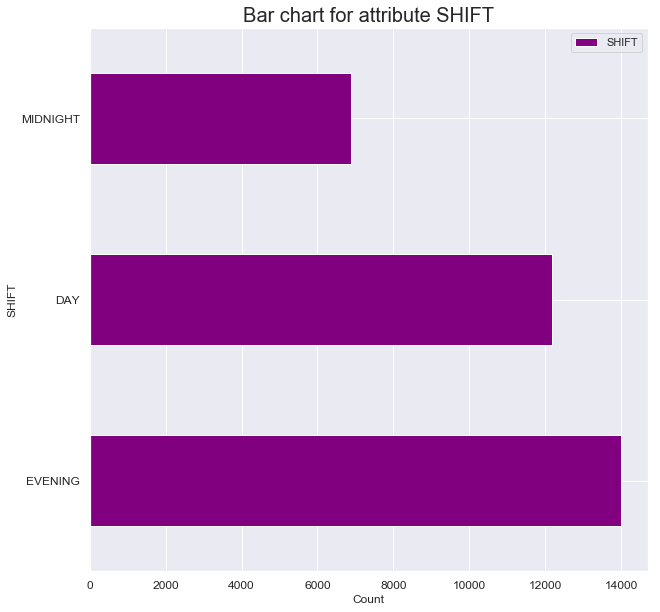

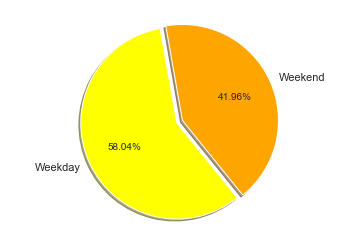

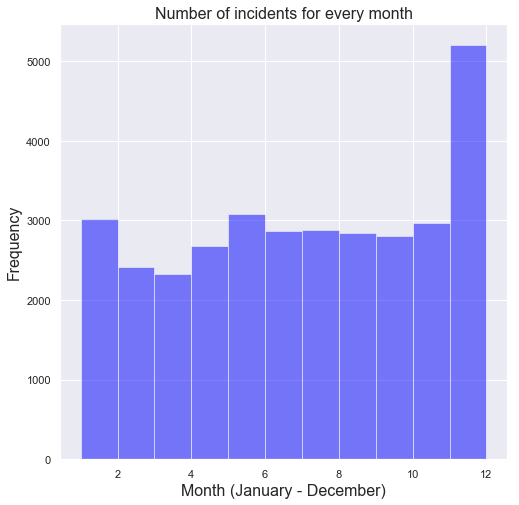

In [11]:
dashboard_measure(data_inventory, 'crime')

### Example for `place` (hospitals)

Total number of hospitals: 17


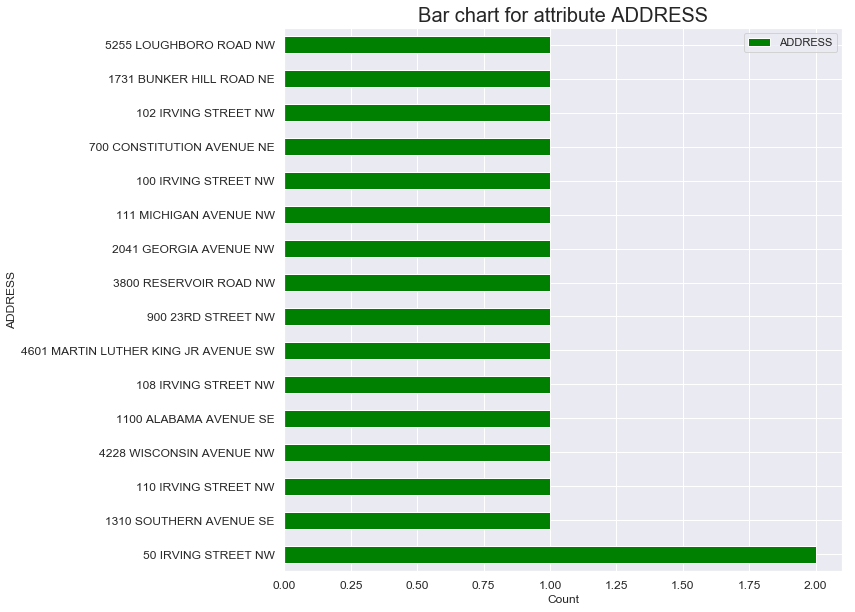

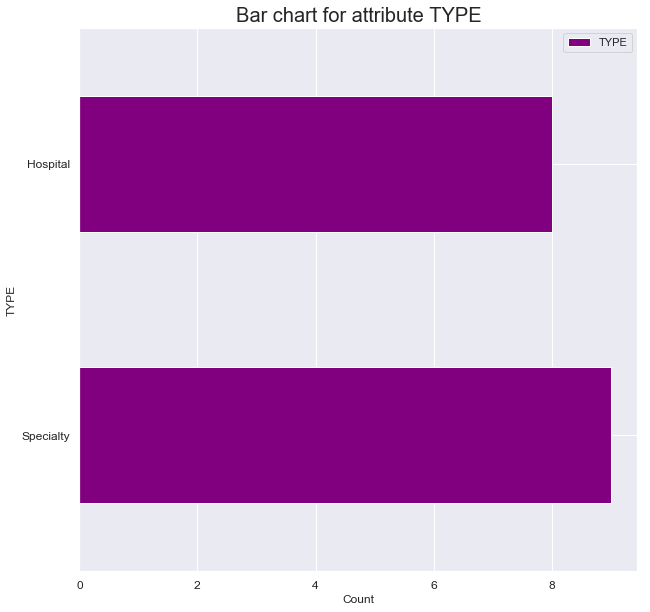

In [12]:
dashboard_place(data_inventory, 'hospitals')

### Example for `boundary` (neighborhood)

Total number of wards: 8


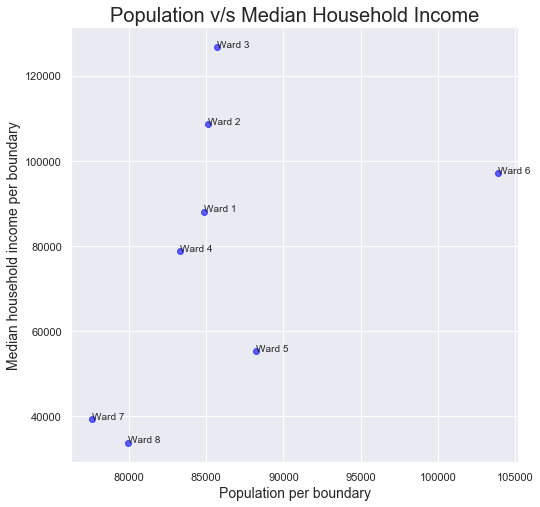

MapView(layout=Layout(height='400px', width='100%'))

In [13]:
dashboard_boundary(data_inventory, 'wards')

![image](https://user-images.githubusercontent.com/13968196/58343889-31bd7b00-7e22-11e9-86a9-a08d76c7c831.png)